## Imports

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
import itertools
import warnings
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression


## Loading Dataset

In [28]:

df_lagged = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\df_lagged.csv")
display(df_lagged.head(3))

,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtelling (%),Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,...,TVV_Lag1,TVV_Lag2,TVV_Lag3,TVV_Lag4,TVV_Lag5,TVV_Lag6,year,month,quarter,Totaal_verkochte_wegvoertuigen
0,2007-07-01,0,1,0,22,14.0,22.0,9.0,6.2,1.451,...,112.0,84.0,62.0,123.0,39.0,31.0,2007,7,3,124
1,2007-08-01,0,1,0,22,12.0,17.0,9.0,5.6,1.415,...,124.0,112.0,84.0,62.0,123.0,39.0,2007,8,3,96
2,2007-09-01,0,1,0,22,10.0,12.0,9.0,5.0,1.422,...,96.0,124.0,112.0,84.0,62.0,123.0,2007,9,3,120


## Data prrocessing

### datasplit

Total walk-forward steps: 43


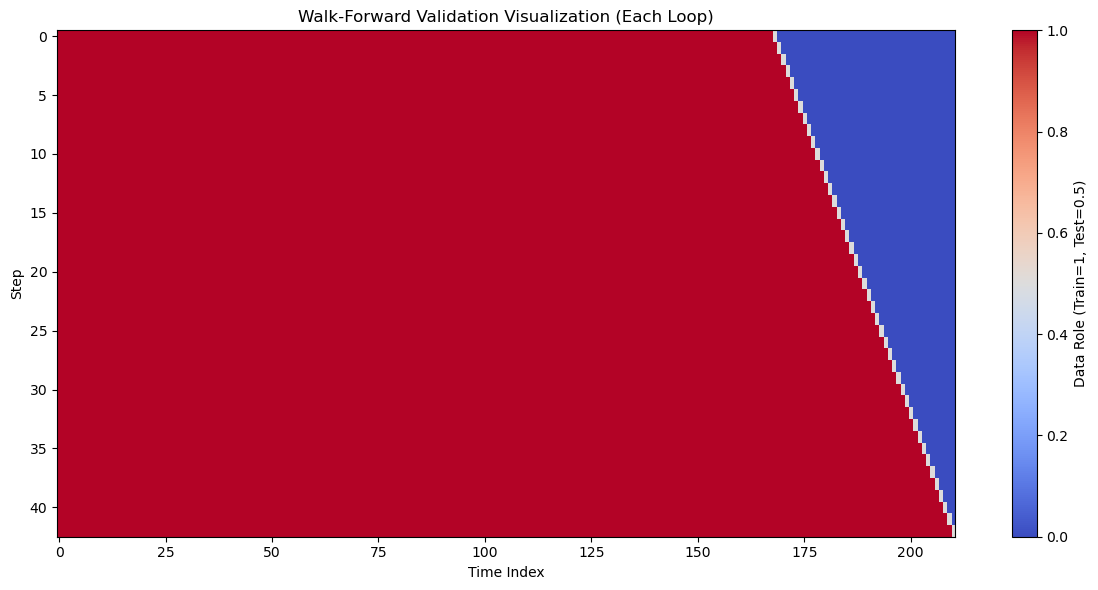

In [29]:
# Walk-forward split: start with 80% as initial train, then identify test points
drop_cols = ['Periode', 'Totaal_verkochte_wegvoertuigen']
target_col = 'Totaal_verkochte_wegvoertuigen'
feature_cols = [col for col in df_lagged.columns if col not in drop_cols]

initial_train_size = int(len(df_lagged) * 0.8)
walkforward_train_sizes = []
walkforward_test_points = []

X = df_lagged[feature_cols].values
y = df_lagged[target_col].values

for i in range(initial_train_size, len(df_lagged)):
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i], y[i]
    
    walkforward_train_sizes.append(len(X_train))
    walkforward_test_points.append(y_test)  # Optional: you can skip storing this

print(f"Total walk-forward steps: {len(walkforward_test_points)}")

# Visualize each walk-forward loop as a matrix (like a CV split matrix)
n_samples = len(df_lagged)
n_steps = len(walkforward_test_points)
visual_matrix = np.zeros((n_steps, n_samples))

for i in range(n_steps):
    train_end = walkforward_train_sizes[i]
    visual_matrix[i, :train_end] = 1  # Train = 1
    visual_matrix[i, train_end] = 0.5  # Test point = 0.5

plt.figure(figsize=(12, 6))
plt.imshow(visual_matrix, aspect='auto', cmap='coolwarm', interpolation='nearest')
plt.title("Walk-Forward Validation Visualization (Each Loop)")
plt.xlabel("Time Index")
plt.ylabel("Step")
plt.colorbar(label="Data Role (Train=1, Test=0.5)")
plt.tight_layout()
plt.show()

In [34]:
# Define lag and time features to add to all subsets
lag_time_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']

# Redefine feature sets with those always included
feature_sets = {
    ' (Lag Only)': lag_time_features,
    'Keywords + Lag': lag_time_features + ['thuis opladen', 'elektrische auto', 'hybride elektrisch'],
    'Bijtelling + Lag': lag_time_features + ['Bijtelling (%)'],
    'Confidence + Lag': lag_time_features + ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen'],
    'Fuel + Lag': lag_time_features + [
        'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
        'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
        'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
    ]
}

# Add full feature set: everything except target and 'Periode'
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
] + lag_time_features

feature_sets['All Features'] = all_features

### Def

In [24]:
# Define lag and time features to add to all subsets
lag_time_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']

# Redefine feature sets with those always included
feature_sets = {
    ' (Lag Only)': lag_time_features,
    'Keywords + Lag': lag_time_features + ['thuis opladen', 'elektrische auto', 'hybride elektrisch'],
    'Bijtelling + Lag': lag_time_features + ['Bijtelling (%)'],
    'Confidence + Lag': lag_time_features + ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen'],
    'Fuel + Lag': lag_time_features + [
        'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
        'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
        'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
    ]
}

# Add full feature set: everything except target and 'Periode'
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
] + lag_time_features

feature_sets['All Features'] = all_features

## Baseline
Baseline Performance Across Models (Default Hyperparameters)

### Linear Regression

In [33]:


# Only use lagged features for linear regression
lagged_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6']

def walk_forward_validation(df, features, target_col):
    """
    Perform walk-forward validation using Linear Regression on the given dataframe.
    Returns MAE, RMSE, R2, and MAPE.
    """
    X = df[features].values
    y = df[target_col].values
    initial_train_size = int(len(df) * 0.8)
    predictions = []
    actuals = []
    for i in range(initial_train_size, len(df)):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i], y[i]
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test.reshape(1, -1))[0]
        predictions.append(y_pred)
        actuals.append(y_test)
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    return mae, rmse, r2, mape, actuals, predictions

# Evaluate walk-forward validation using only lagged features
mae, rmse, r2, mape = walk_forward_validation(df_lagged, lagged_features, 'Totaal_verkochte_wegvoertuigen')

print(f"Linear Regression Walk-Forward (Lagged Features Only):")
print(f"MAPE: {mape:.2f}%")

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Plot actual vs predicted values for the walk-forward validation (Lagged Features Only)
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual', marker='o')
plt.plot(predictions, label='Predicted (Linear Regression)', marker='x')
plt.title('Actual vs Predicted (Walk-Forward Validation, Lagged Features Only)')
plt.xlabel('Test Sample Index')
plt.ylabel('Totaal_verkochte_wegvoertuigen')
plt.legend()
plt.tight_layout()
plt.show()


ValueError: too many values to unpack (expected 4)

#### Lag only

Linear Regression Walk-Forward (All Features):
MAPE: 15.48%
MAE: 3386.96
RMSE: 4441.61
R²: 0.4925


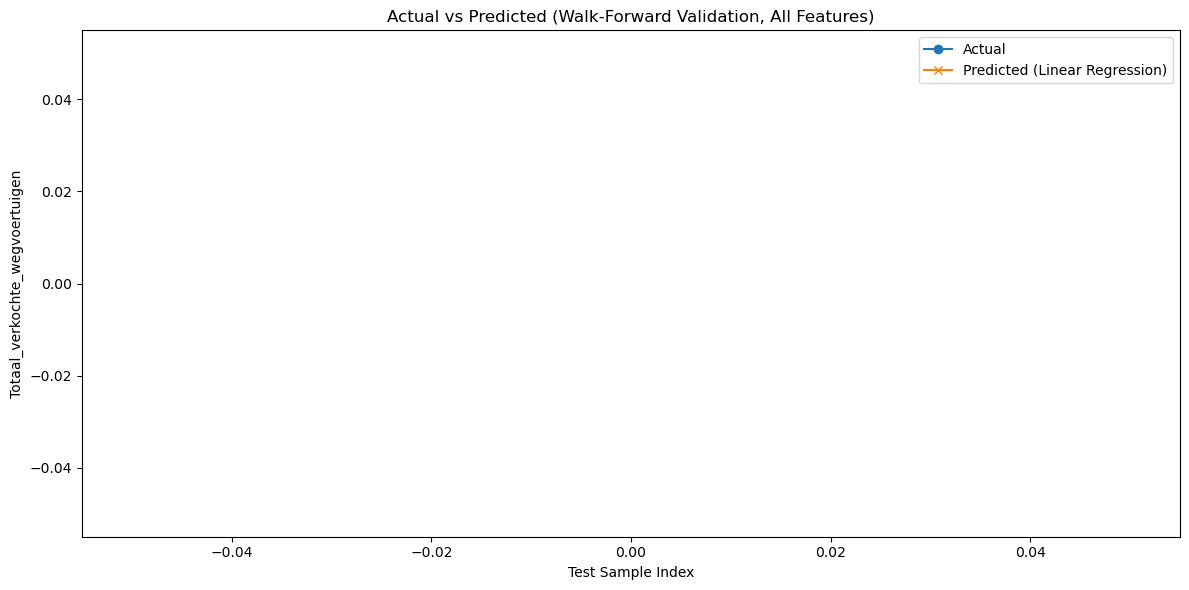

In [31]:
from sklearn.linear_model import LinearRegression

def walk_forward_validation(df, features, target_col):
    """
    Perform walk-forward validation using Linear Regression on the given dataframe.
    Returns MAE, RMSE, R2, and MAPE.
    """
    X = df[features].values
    y = df[target_col].values
    initial_train_size = int(len(df) * 0.8)
    predictions = []
    actuals = []
    for i in range(initial_train_size, len(df)):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i], y[i]
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test.reshape(1, -1))[0]
        predictions.append(y_pred)
        actuals.append(y_test)
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    return mae, rmse, r2, mape

# Evaluate walk-forward validation using all features (feature_cols)
mae, rmse, r2, mape = walk_forward_validation(df_lagged, feature_cols, 'Totaal_verkochte_wegvoertuigen')

print(f"Linear Regression Walk-Forward (All Features):")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Plot actual vs predicted values for the walk-forward validation (All Features)
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual', marker='o')
plt.plot(predictions, label='Predicted (Linear Regression)', marker='x')
plt.title('Actual vs Predicted (Walk-Forward Validation, All Features)')
plt.xlabel('Test Sample Index')
plt.ylabel('Totaal_verkochte_wegvoertuigen')
plt.legend()
plt.tight_layout()
plt.show()

